# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) June 21st 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     144   ()      
  1  SCI         ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT      ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF        ImageHDU         7   (533678773,)   uint8   


#### show the last frame of the first integration for each file

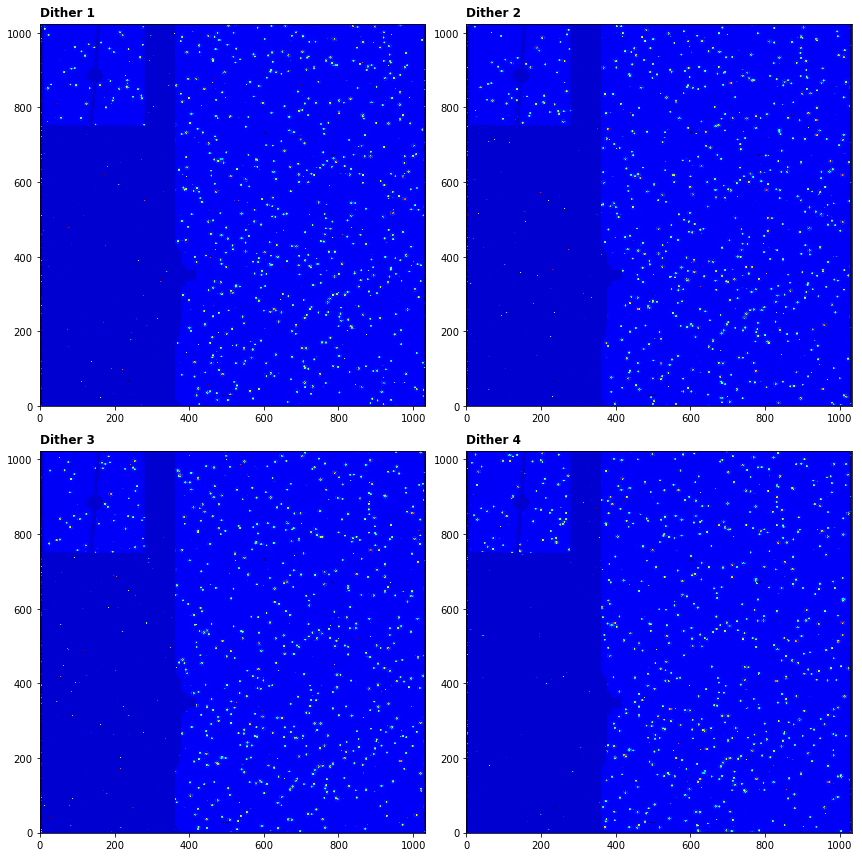

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import SloperPipeline
print SloperPipeline.__doc__



    SloperPipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    and ramp_fit.

    


For MIRI, the steps in order are: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

NOTE: As dark current was switched off in the MIRISim simulations, we will skip the dark_current step in the call to the SloperPipeline

#### run pipeline
The output of the level 2A pipeline is contained in the dm_2A data model, which we add to a model container. This s also saved to a fits file ending in '_rate.fits'. Saving the fits file is optional

In [6]:
dm_2A_container = datamodels.ModelContainer()
for input_file in input_files:
    dm_2A = SloperPipeline.call(input_file, save_results=True, output_dir=output_dir, steps={'dark_current':{'skip':True}})
    dm_2A_container.append(dm_2A)

2017-06-28 22:02:01,396 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-06-28 22:02:01,397 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-06-28 22:02:01,399 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-06-28 22:02:01,400 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-06-28 22:02:01,402 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-06-28 22:02:01,403 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-06-28 22:02:01,405 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-06-28 22:02:01,406 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-06-28 22:02:01,407 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-06-28 22:02:01,409 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-06-28 22:02:01,410 - stpipe.SloperPipeline.dq_ini

#### quick check of output. We'll look at the first dither

In [7]:
# check the calibration step information
print'Check step information status:'
print 'dq_init: %s' % dm_2A_container[0].meta.cal_step.dq_init
print 'saturation: %s' % dm_2A_container[0].meta.cal_step.saturation
print 'linearity: %s' % dm_2A_container[0].meta.cal_step.linearity
print 'rscd: %s' % dm_2A_container[0].meta.cal_step.rscd
print 'lastframe: %s' % dm_2A_container[0].meta.cal_step.lastframe
print 'dark_current: %s' % dm_2A_container[0].meta.cal_step.dark_sub
print 'refpix: %s' % dm_2A_container[0].meta.cal_step.refpix
print 'jump: %s' % dm_2A_container[0].meta.cal_step.jump
print 'ramp_fit: %s' % dm_2A_container[0].meta.cal_step.ramp_fit

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Image2Pipeline
print Image2Pipeline.__doc__



    CalWebbImage2: Processes JWST imaging-mode slope images from
                   Level-2a to Level-2b.

    Included steps are:
    assign_wcs, flat_field, and photom.

    


#### run pipeline
We pass the level 2A data model container. The output is contained in the dm_2B data model and saved to a fits file ending in '_image2pipeline.fits'. Saving this fits file is optional. 

In [9]:
for dm_2A in dm_2A_container:
    dm_2B = Image2Pipeline.call(dm_2A, save_results=True, output_dir=output_dir)


2017-06-28 22:43:25,895 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2017-06-28 22:43:25,897 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-06-28 22:43:25,899 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-06-28 22:43:25,900 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2017-06-28 22:43:27,224 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-06-28 22:43:27,224 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-06-28 22:43:27,225 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-06-28 22:43:27,226 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf'.
2017-06-28 22:43:27,227 - stpipe.Image2Pipeline.assign_wcs - INFO - Pre

### check of output

In [10]:
# set the output file names
level2B_file = glob.glob(os.path.join(output_dir,'*_image2pipeline.fits'))[0]

#### level 2B file

In [11]:
# check the calibration step information
print'Check step information status:'
print 'assign_wcs: %s' % dm_2B.meta.cal_step.assign_wcs
print 'flat_field: %s' % dm_2B.meta.cal_step.flat_field
print 'photom: %s' % dm_2B.meta.cal_step.photom


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
photom: COMPLETE


#### calibrated image

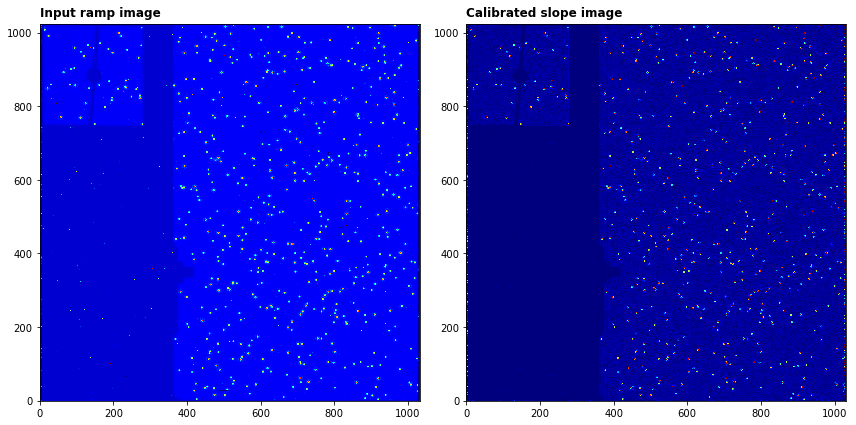

In [12]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_file) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_image2pipeline.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. Note the the image alignment step tweakreg is currently not working. Therefore, we skip this step and the associated tweakreg_catalog step. We also skip the source_catalog step.

In addition, we must include some WCS metadata which is not included by MIRISim. When and how this metadata will be included is under discussion but for now we add it manually to the level 2B output.

The output combined image file will be contained in 'ima_dither_i2d.fits'

In [13]:
cal_files = glob.glob(os.path.join(output_dir,'*_image2pipeline.fits'))

# add the WCS info
for f in cal_files:
    a = datamodels.open(f)
    a.meta.wcsinfo.cdelt1 = 0.110459 / 3600
    a.meta.wcsinfo.cdelt2 = 0.111481 / 3600
    a.meta.wcsinfo.pc1_1 = -1.0
    a.meta.wcsinfo.wcsaxes = 2
    a.meta.wcsinfo.ctype1 = 'RA---TAN '
    a.meta.wcsinfo.ctype2 = 'DEC--TAN'
    a.meta.wcsinfo.cunit1 = 'deg     '
    a.meta.wcsinfo.cunit2 = 'deg     '
    a.meta.wcsinfo.vparity = -1
    a.meta.wcsinfo.v3yangle = 5.0152
    a.save(os.path.join(output_dir,a.meta.filename))


#for n,cal_file in enumerate(cal_files): cal_files[n] = os.path.basename(cal_file)
call(["asn_from_list", "-o", "IMA_asn.json"] + cal_files + ["--product-name", "ima_dither"])


0

#### import the level 3 pipeline class and print description

In [14]:
from jwst.pipeline import Image3Pipeline
print Image3Pipeline.__doc__


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg_catalog
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


#### run pipeline

In [15]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")
dm_3 = Image3Pipeline.call(dm_3_container, save_results=True, steps={'tweakreg':{'skip':True},
                                                                    'tweakreg_catalog':{'skip':True},
                                                                    'source_catalog':{'skip':True}})

# there are issues with how Image3Pipeline writes and reads files. For now, we output them in
# the working directory and then move them to the output_dir
for file in glob.glob('*a3001.fits'): shutil.move(file,os.path.join(output_dir,file))
shutil.move('ima_dither_i2d.fits',os.path.join(output_dir,'ima_dither_i2d.fits'))
shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))

2017-06-28 22:44:57,639 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2017-06-28 22:44:57,641 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2017-06-28 22:44:57,643 - stpipe.Image3Pipeline.tweakreg_catalog - INFO - TweakregCatalogStep instance created.
2017-06-28 22:44:57,645 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2017-06-28 22:44:57,648 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2017-06-28 22:44:57,650 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2017-06-28 22:44:57,652 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2017-06-28 22:44:57,935 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (<jwst.datamodels.container.ModelContainer object at 0x1201b49d0>,).
2017-06-28 22:44:57,937 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...
2017-06-28 22:44:58,069 - stpipe.Ima

#### plot the drizzled file

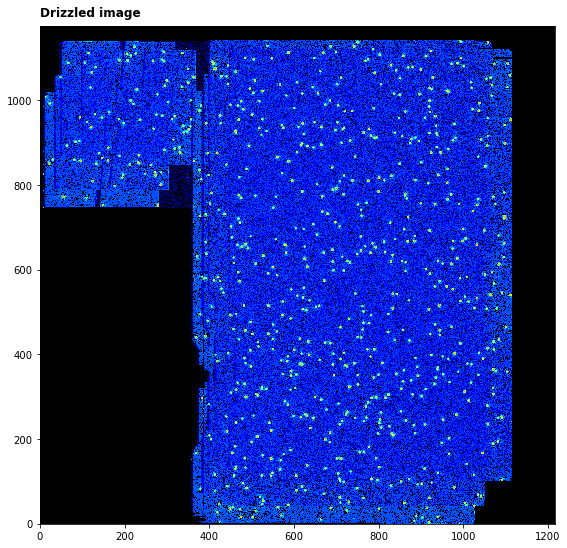

In [16]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()